In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
cmtes_csv = f"./data/CampaignFin{year}/cmtes{year}.txt"

In [34]:
bundlers_data = {
    'metric': ['Indians', 'Total', 'Percentage'],
    'Obama (2008)': [11, 557, 1.974865350],
    'Obama (2012)': [10, 769, 1.300390117],
    'Clinton (2016)': [32, 1409, 2.271114265],
    'Biden (2020)': [25, 815, 3.067484663]
}

bundlers = pd.DataFrame(bundlers_data).T
bundlers.columns = bundlers.iloc[0]
bundlers = bundlers.iloc[1:]
bundlers

metric,Indians,Total,Percentage
Obama (2008),11.0,557.0,1.974865
Obama (2012),10.0,769.0,1.30039
Clinton (2016),32.0,1409.0,2.271114
Biden (2020),25.0,815.0,3.067485


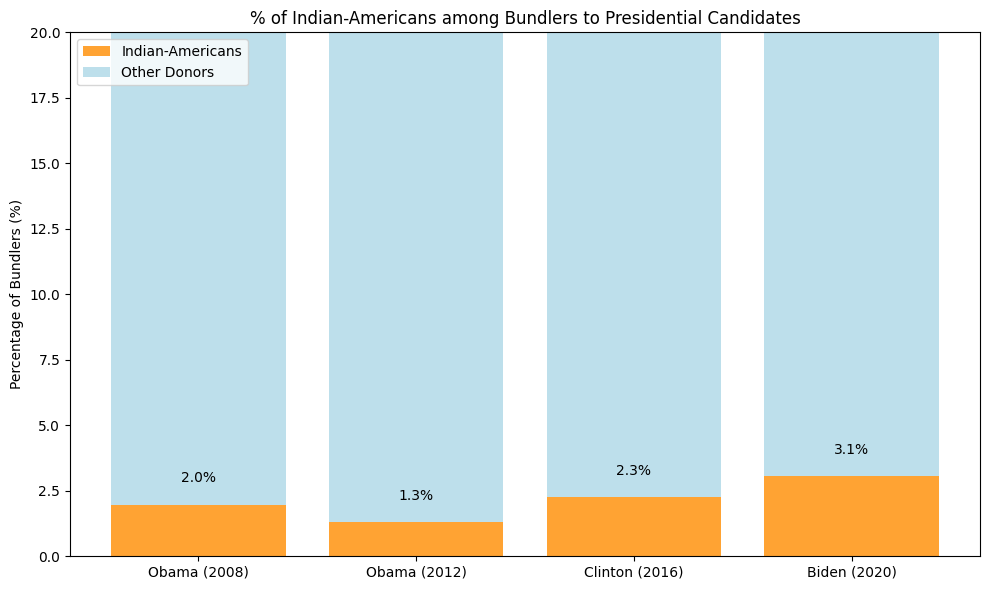

In [37]:
bundlers['Other Donors'] = bundlers['Total'] - bundlers['Indians']
bundlers['Indian_Pct'] = (bundlers['Indians'] / bundlers['Total']) * 100
bundlers['Non_Indian_Pct'] = 100 - bundlers['Indian_Pct']

fig, ax = plt.subplots(figsize=(10, 6))
bars2 = ax.bar(bundlers.index, bundlers['Indian_Pct'], label='Indian-Americans', alpha=0.8, color='darkorange')
bars1 = ax.bar(bundlers.index, bundlers['Non_Indian_Pct'], bottom=bundlers['Indian_Pct'], label='Other Donors', alpha=0.8, color='lightblue')

for i, metric in enumerate(bundlers.index):
    indian_pct = bundlers.loc[metric, 'Indian_Pct']
    ax.text(i, bundlers.loc[metric, 'Indian_Pct'] + 1, 
            f'{indian_pct:.1f}%', ha='center', va='center',
            color='white' if indian_pct > 30 else 'black') 

ax.set_ylabel('Percentage of Bundlers (%)')
ax.set_ylim(0, 20)
ax.set_title('% of Indian-Americans among Bundlers to Presidential Candidates')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [56]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.086565e+09,868,1.251802e+06,612.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.179460e+08,582,5.462989e+05,2036.5
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,9.947018e+07,589,1.688798e+05,250.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,9.866908e+07,122,8.087629e+05,117035.5
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,9.195982e+07,197,4.668011e+05,500.0
5,,C00571703,CHEVRON CORPORATION,koch industries inc koch industries inc,Y4000,,NaN,NaN,WASHINGTON,TX,6.460129e+07,212,3.047231e+05,50000.0
6,,C00495028,CHC BOLD PAC,chc bold pac chc bold pac,Z9600,,NaN,NaN,WASHINGTON,DC,5.408387e+07,207,2.612747e+05,70000.0
7,,C00693382,FUND FOR POLICY REFORM,fund for policy reform fund for policy reform,J1200,,NaN,NaN,WILMINGTON,DE,4.950000e+07,7,7.071429e+06,6000000.0
8,,C00669259,FUTURE FORWARD USA ACTION,future forward usa action future forward usa a...,J1200,,NaN,NaN,WASHINGTON,DC,4.526326e+07,27,1.676417e+06,100000.0
9,,C00504530,AMERICAN ACTION NETWORK,american action network american action network,Z9600,,NaN,NaN,WASHINGTON,DC,4.465169e+07,138,3.235630e+05,100000.0


In [57]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [58]:
lf = (
        pl.scan_csv(
            cmtes_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'cmte_id', 'pac_short', 'affiliate', 'pac', 
                        'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code', 
                        'source', 'sensitive', 'foreign', 'active'],
            ignore_errors=True
        )
        .select(['cmte_id', 'pac_short', 'affiliate', 'pac',
                 'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code',
                 'source', 'sensitive', 'foreign', 'active'])
    )
cmtes = lf.collect(streaming=True)
cmtes = cmtes.to_pandas()
cmtes[cmtes["party"] == "L"]

,cmte_id,pac_short,affiliate,pac,recip_id,recipcode,cand_id,party,prim_code,source,sensitive,foreign,active
1426,C00255695,Libertarian National Cmte,Libertarian Party,Libertarian Party,C00255695,3P,None,L,Z5300,Rept,n,0,1
1745,C00315713,Libertarian Party of Illinois,Libertarian Party,Libertarian Party,C00315713,3P,None,L,Z5300,Rept,N,0,1
1878,C00332221,Libertarian Assn of Massachusetts,Libertarian Party,Libertarian Party,C00332221,3P,None,L,Z5300,Rept,N,0,1
2649,C00399865,Libertarian Party of Virginia,Libertarian Party,Libertarian Party,C00399865,3P,None,L,Z5300,Rept,N,0,1
2658,C00400945,Libertarian Party of South Carolina,Libertarian Party,Libertarian Party,C00400945,3P,None,L,Z5300,Rept,n,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16745,C00758250,Liz Terwilliger for Congress,None,Liz Terwilliger for Congress,N00047569,3L,H0PA12207,L,Z1300,Rept,N,0,1
16861,C00759423,COMMITTEE TO ELECT TWHAMBY ...,None,None,C00759423,None,None,L,None,None,None,0,0
17029,C00761130,PRESTON NELSON FOR CONGRESS ...,None,None,N00042426,3L,H0IL08165,L,None,None,N,0,0
17181,C00762732,ITSBEAUTIME ...,None,None,N00047809,3N,P40004277,L,None,None,N,0,0


In [59]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    1299587
Unknown                  1036328
Ideology/Single Issue     861610
Health                    541522
Finance                   443132
Tech                      224719
Law                       199207
Construction              122016
Transportation            118605
Labor                     112626
Energy                     89268
Agribusiness               73594
Manufacturing              55259
Defense                    37952
Name: count, dtype: int64

In [60]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [61]:
donors = donors.merge(cmtes[
    ["cmte_id", "pac_short", "affiliate", "pac", "recip_id", "recipcode", "cand_id", "party"]], 
    left_on='recip_id', right_on="cmte_id", how='left', suffixes=[None, "_pac"]
    ).drop_duplicates(subset=['contrib_id', 'recip_id', 'cmte_id'], keep='last')

donors.loc[donors["pac"].notna(), "name_y"] = donors.loc[donors["pac"].notna(), "pac"]
donors.loc[donors["pac_short"].notna(), "name_y"] = donors.loc[donors["pac_short"].notna(), "pac_short"]

donors["recip_is_pac"] = False
donors.loc[donors["pac_short"].notna(), "recip_is_pac"] = True

donors.loc[donors["pac_short"].notna(), "party"] = donors.loc[donors["pac_short"].notna(), "party_pac"]

In [62]:
donors.loc[donors["name_y"] == "Stop Republicans PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Senate Majority PAC", "party"] = "D"
donors.loc[donors["name_y"] == "314 Action Fund", "party"] = "D"
donors.loc[donors["name_y"] == "Progressive Takeover", "party"] = "D"
donors.loc[donors["name_y"] == "Black Americans to Re-Elect the President", "party"] = "R"
donors.loc[donors["name_y"] == "National Victory Action Fund", "party"] = "R"
donors.loc[donors["name_y"] == "MeidasTouch", "party"] = "D"
donors.loc[donors["name_y"] == "Swing Left", "party"] = "D"
donors.loc[donors["name_y"] == "Democratic Strategy Institute", "party"] = "D"
donors.loc[donors["name_y"] == "Senate Leadership Fund", "party"] = "R"
donors.loc[donors["name_y"] == "America First Action", "party"] = "R"
donors.loc[donors["name_y"] == "Future Forward USA", "party"] = "D"
donors.loc[donors["name_y"] == "Unite the Country", "party"] = "D"
donors.loc[donors["name_y"] == "Need to Impeach", "party"] = "D"
donors.loc[donors["name_y"] == "Tech for Campaigns", "party"] = "D"
donors.loc[donors["name_y"] == "Georgia Honor", "party"] = "D"
donors.loc[donors["name_y"] == "The Georgia Way", "party"] = "D"
donors.loc[donors["name_y"] == "Citizens for Free Enterprise", "party"] = "R"
donors.loc[donors["name_y"] == "Tom Steyer PAC", "party"] = "D"
donors.loc[donors["name_y"] == "GOPAC", "party"] = "R"
donors.loc[donors["name_y"] == "LMG PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Democratic Majority for Israel", "party"] = "D"
donors.loc[donors["name_y"] == "Plains PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Future Now Fund PAC", "party"] = "D"
donors.loc[donors["name_y"] == "House Freedom Action", "party"] = "R"
donors.loc[donors["name_y"] == "Way to Lead PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Better Future Michigan Fund", "party"] = "R"
donors.loc[donors["name_y"] == "Digidems PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Justice & Public Safety", "party"] = "D"
donors.loc[donors["name_y"] == "Casa in Action PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Conservative Outsider PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Save America Fund", "party"] = "D"
donors.loc[donors["name_y"] == "People Standing Strong", "party"] = "D"
donors.loc[donors["name_y"] == "State Government Citizens' Campaign", "party"] = "D"
donors.loc[donors["name_y"] == "Mind the Gap", "party"] = "D"
donors.loc[donors["name_y"] == "Elect Democratic Women", "party"] = "D"
donors.loc[donors["name_y"] == "Everyday People PAC", "party"] = "D"
donors.loc[donors["name_y"] == "For Our Families PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Save the US Senate PAC", "party"] = "R"
donors.loc[donors["name_y"] == "One Vote at a Time", "party"] = "D"
donors.loc[donors["name_y"] == "Humanity Forward Fund", "party"] = "D"
donors.loc[donors["name_y"] == "One Vote at a Time", "party"] = "D"
donors.loc[donors["name_y"] == "American Patriots PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Virginia Plus PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Valor America", "party"] = "R"
donors.loc[donors["name_y"] == "United We Win", "party"] = "D"
donors.loc[donors["name_y"] == "New South Super PAC", "party"] = "D"
donors.loc[donors["name_y"] == "March On PAC", "party"] = "D"
donors.loc[donors["name_y"] == "L PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Louisiana Legacy PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Our Future United", "party"] = "D"
donors.loc[donors["name_y"] == "New American Jobs Fund", "party"] = "D"
donors.loc[donors["name_y"] == "Patriots of America PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Sister District Project", "party"] = "D"
donors.loc[donors["name_y"] == "Abolitionists PAC", "party"] = "D"
donors.loc[donors["name_y"] == "California Democracy Ventures Fund", "party"] = "D"
donors.loc[donors["name_y"] == "WinRed", "party"] = "R"

In [63]:
donors.groupby(["name_y", "party"])["total_donated"].sum().sort_values(ascending=False)[:10]

name_y                               party
Michael Bloomberg (D)                D        1.086629e+09
WinRed                               R        7.205965e+08
Joe Biden (D)                        D        6.818375e+08
Donald Trump (R)                     R        4.763821e+08
Republican National Cmte             R        4.361667e+08
Biden Victory Fund                   D        3.860870e+08
Trump Make America Great Again Cmte  R        3.667061e+08
Trump Victory                        R        3.418192e+08
DNC Services Corp                    D        3.291139e+08
Tom Steyer (D)                       D        3.202495e+08
Name: total_donated, dtype: float64

In [64]:
contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,cmte_id,pac_short,affiliate,pac,recip_id_pac,recipcode_pac,cand_id,party_pac,recip_is_pac,dem_ratio
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,C00484642,Senate Majority PAC,Senate Majority PAC,Senate Majority PAC,C00484642,OI,None,,True,1.0
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,C00618371,Trump Make America Great Again Cmte,None,Trump Make America Great Again Cmte,C00618371,RP,None,R,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136231,h3001209792,N00040675,"GOULD, COLIN",colin gould,C5120,M,SOFTWARE INFRASTRUCTURE ARCHITECT,ORACLE,FOSTER CITY,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
7136232,p0001372401,C00003418,"BLEDSOE, PEARLIOUS MS",pearlious ms bledsoe,X1200,F,RETIRED,RETIRED,GRANITEVILLE,SC,...,C00003418,Republican National Cmte,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0
7136233,r0006423692,C00003418,"CARMICHAEL, RUTH",ruth carmichael,X1200,F,RETIRED,RETIRED,KANSAS CITY,KS,...,C00003418,Republican National Cmte,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0
7136234,r0015995400,C00003418,"BOOKATZ, DEBRA MRS",debra mrs bookatz,Y4000,F,RETIRED,MARINE CORP. COMMUNITY SERVICES,KANEOHE,HI,...,C00003418,Republican National Cmte,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0


In [65]:
donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"] = donors.apply(lambda x: "PAC" if x["level"] == "Unknown" and x["recip_is_pac"] == True else x["level"], axis=1)
donors["level"].value_counts()

level
PAC          3446366
Senate       1462832
President    1380460
House         845529
Unknown         1049
Name: count, dtype: int64

In [66]:
house_csv = f"C:/Users/Karnav/Downloads/1976-2022-house.csv"
house = pd.read_csv(house_csv)
house = house[~house["candidate"].isin(["WRITEIN", "OTHER", "BLANK VOTE/SCATTERING", "BLANK VOTE", "UNDERVOTES", "OVERVOTES", "BLANK VOTE/VOID VOTE/SCATTERING", "VOID", "SCATTERING"])]
house[house["year"] == 2000 + year]

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version,fusion_ticket
29636,2020,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,False,JAMES AVERHART,DEMOCRAT,False,TOTAL,116949,329075,False,20230706,False
29637,2020,ALABAMA,AL,1,63,41,US HOUSE,1,GEN,False,False,JERRY CARL,REPUBLICAN,False,TOTAL,211825,329075,False,20230706,False
29639,2020,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,False,False,BARRY MOORE,REPUBLICAN,False,TOTAL,197996,303569,False,20230706,False
29640,2020,ALABAMA,AL,1,63,41,US HOUSE,2,GEN,False,False,PHYLLIS HARVEY-HALL,DEMOCRAT,False,TOTAL,105286,303569,False,20230706,False
29642,2020,ALABAMA,AL,1,63,41,US HOUSE,3,GEN,False,False,ADIA WINFREY,DEMOCRAT,False,TOTAL,104595,322234,False,20230706,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31094,2020,WISCONSIN,WI,55,35,25,US HOUSE,8,GEN,False,False,MIKE GALLAGHER,REPUBLICAN,False,TOTAL,268173,417838,False,20230706,False
31096,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,JEFF HAGGIT,CONSTITUTION,False,TOTAL,7905,278503,False,20230706,False
31097,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,LIZ CHENEY,REPUBLICAN,False,TOTAL,185732,278503,False,20230706,False
31098,2020,WYOMING,WY,56,83,68,US HOUSE,0,GEN,False,False,LYNNETTE GREY BULL,DEMOCRAT,False,TOTAL,66576,278503,False,20230706,False


In [67]:
house20 = house[house["year"] == 2000 + year]
house20["party"] = house20.apply(lambda x: str(x["party"]).upper()[0], axis=1)
house20["party"] = house20["party"].apply(lambda x: "3" if x not in ["D", "R", "L", "I"] else x)
house20["party"].value_counts()

party
D    445
R    422
3    220
L    124
I     57
Name: count, dtype: int64

In [68]:
house20["district"] = house20.apply(lambda x: 1 if x["district"] == 0 and x["state_po"] != "DC" else 0 if x["district"] == 1 and x["state_po"] == "DC" else x["district"], axis=1)
house20["seat"] = house20.apply(lambda x: x["state_po"] + ("0" + str(x["district"]) if x["district"] < 10 else str(x["district"])), axis=1)
house20["lastname"] = house20.apply(lambda x: str(x["candidate"]).lower().replace('"', '').split(" ")[-1], axis=1)
house20[["seat", "party", "lastname"]].value_counts()

seat  party  lastname   
NY02  3      garbarino      2
NY20  3      joy            2
NY26  3      higgins        2
NY19  3      delgado        2
NY06  3      zmich          2
                           ..
IN08  R      bucshon        1
      L      rodenberger    1
      D      marsili        1
IN07  R      smith          1
WY01  R      cheney         1
Name: count, Length: 1263, dtype: int64

In [69]:
donors["lastname"] = donors["name_y"].apply(lambda x: str(x).lower().replace('"', '').split(" ")[-2] if len(str(x).split(" ")) > 1 else str(x).split(" ")[0])
donors["lastname"] = donors.apply(lambda x: "baldwin-kennedy" if x["seat"] == "CA26" and "kennedy" in x["lastname"] 
                                  else "jr" if x["seat"] == "CA39" and "cisneros" in x["lastname"] 
                                  else "iii" if x["seat"] == "CA43" and "collins" in x["lastname"] 
                                  else "jr" if x["seat"] == "CA51" and "hidalgo" in x["lastname"] 
                                  else "jr" if x["seat"] == "FL05" and "lawson" in x["lastname"] 
                                  else "jr" if x["seat"] == "GA02" and "bishop" in x["lastname"] 
                                  else "jr" if x["seat"] == "GA04" and "johnson" in x["lastname"] 
                                  else "jr" if x["seat"] == "LA05" and "lemelle" in x["lastname"] 
                                  else x["lastname"], axis=1)
donors["party"] = donors.apply(lambda x: "D" if (x["seat"] == "AK01" and x["lastname"] == "galvin") or (x["seat"] == "CA29" and x["lastname"] == "duenas") else x["party"], axis=1)
donors[(donors["recip_is_pac"] == False) & (donors["level"] == "House") & (donors["ran_general"] == "Y")][["seat", "party", "lastname"]].value_counts()

seat  party  lastname
LA01  R      scalise     80083
CA22  R      nunes       20305
OH04  R      jordan      16291
TX02  R      crenshaw    14727
CA28  D      schiff      11424
                         ...  
CA19  R      aguilera        1
GA05  D      waites          1
GA04  R      cruz            1
NY05  I      lal             1
IN09  L      millis          1
Name: count, Length: 815, dtype: int64

In [70]:
donors[(donors["recip_is_pac"] == False) & (donors["level"] == "House")]

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,affiliate,pac,recip_id_pac,recipcode_pac,cand_id,party_pac,recip_is_pac,dem_ratio,level,lastname
68,U0000003039A,N00042222,"WALL, KATHALEEN",kathaleen wall,Z9000,F,RETIRED,RETIRED,HOUSTON,TX,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000,House,wall
78,p0005023768,N00007017,"ISSA - PERSONAL FUNDS, DARRELL",darrell issa - personal funds,Z9000,M,NaN,NaN,VISTA,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000,House,issa
122,r0002103420,N00042081,"JACOBS, SARA",sara jacobs,Z9000,F,SCHOLAR IN RESIDENCE,"KROC SCHOOL, UNIVERSITY OF SAN DIEGO",SAN DIEGO,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.000000,House,jacobs
188,U00000046381,N00039122,"TRONE, DAVID",david trone,Z9000,M,CONGRESSMAN,US CONGRESS,BETHESDA,MD,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.999577,House,trone
236,r0006848113,N00046167,"STREICKER, MARGARET",margaret streicker,Z9000,F,PRESIDENT,NEWCASTLE REALTY SERVICES,MILFORD,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000,House,streicker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136199,m0002112619,N00034016,"LEWIS, JANICE",janice lewis,Y4000,F,SPECIAL PROJECTS,MS SOS,OLIVE BRANCH,MS,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000,House,donalds
7136200,q0001801485@,N00009660,"DRINKWATER, GENEVA",geneva drinkwater,J1100,F,RETIRED,RETIRED,COTTONWOOD,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000,House,scalise
7136202,m0001712882@,N00039503,"MEUNIER, JOANN",joann meunier,J1100,F,RETIRED,RETIRED,LONGMEADOW,MA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000000,House,gaetz
7136203,j1002485395,N00040865,"BALL, DALE",dale ball,J1200,M,NOT EMPLOYED,NOT EMPLOYED,LA CANADA FLINTRIDGE,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.000000,House,porter


In [71]:
donors_unique = donors.drop_duplicates(subset=['seat', 'party', 'name_y', 'level', 'ran_general'])
merged = pd.merge(
    donors[(donors["recip_is_pac"] == False) & (donors["level"] == "House")],
    house20.loc[:, ~house20.columns.isin(["state", "state_po", "district", "state_fips", "state_cen", "state_ic", "office", "version", "fusion_ticket", "stage", "runoff", "special", "writein", "mode", "unofficial"])],
    on=['seat', 'party', 'lastname'],
    how='left',
    suffixes=('', '_vote')
)
merged

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,cand_id,party_pac,recip_is_pac,dem_ratio,level,lastname,year,candidate,candidatevotes,totalvotes
0,U0000003039A,N00042222,"WALL, KATHALEEN",kathaleen wall,Z9000,F,RETIRED,RETIRED,HOUSTON,TX,...,NaN,NaN,False,0.000000,House,wall,NaN,NaN,NaN,NaN
1,p0005023768,N00007017,"ISSA - PERSONAL FUNDS, DARRELL",darrell issa - personal funds,Z9000,M,NaN,NaN,VISTA,CA,...,NaN,NaN,False,0.000000,House,issa,2020.0,DARRELL ISSA,195521.0,362390.0
2,r0002103420,N00042081,"JACOBS, SARA",sara jacobs,Z9000,F,SCHOLAR IN RESIDENCE,"KROC SCHOOL, UNIVERSITY OF SAN DIEGO",SAN DIEGO,CA,...,NaN,NaN,False,1.000000,House,jacobs,2020.0,SARA JACOBS,199244.0,334858.0
3,U00000046381,N00039122,"TRONE, DAVID",david trone,Z9000,M,CONGRESSMAN,US CONGRESS,BETHESDA,MD,...,NaN,NaN,False,0.999577,House,trone,2020.0,DAVID J TRONE,215540.0,366434.0
4,r0006848113,N00046167,"STREICKER, MARGARET",margaret streicker,Z9000,F,PRESIDENT,NEWCASTLE REALTY SERVICES,MILFORD,CT,...,NaN,NaN,False,0.000000,House,streicker,2020.0,MARGARET STREICKER,131568.0,346103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845524,m0002112619,N00034016,"LEWIS, JANICE",janice lewis,Y4000,F,SPECIAL PROJECTS,MS SOS,OLIVE BRANCH,MS,...,NaN,NaN,False,0.000000,House,donalds,2020.0,BYRON DONALDS,272440.0,444589.0
845525,q0001801485@,N00009660,"DRINKWATER, GENEVA",geneva drinkwater,J1100,F,RETIRED,RETIRED,COTTONWOOD,CA,...,NaN,NaN,False,0.000000,House,scalise,2020.0,STEVE SCALISE,270330.0,374369.0
845526,m0001712882@,N00039503,"MEUNIER, JOANN",joann meunier,J1100,F,RETIRED,RETIRED,LONGMEADOW,MA,...,NaN,NaN,False,0.000000,House,gaetz,2020.0,MATT GAETZ,283352.0,438562.0
845527,j1002485395,N00040865,"BALL, DALE",dale ball,J1200,M,NOT EMPLOYED,NOT EMPLOYED,LA CANADA FLINTRIDGE,CA,...,NaN,NaN,False,1.000000,House,porter,2020.0,KATIE PORTER,221843.0,414939.0


In [72]:
donors.drop_duplicates(subset=['contrib_id'])

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,affiliate,pac,recip_id_pac,recipcode_pac,cand_id,party_pac,recip_is_pac,dem_ratio,level,lastname
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,bloomberg
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,steyer
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,biden
16,U0000000310A,C00504530,"ADELSON, MIRIAM",miriam adelson,H3200,F,PHYSICIAN,ADELSON DRUG CLINIC,LAS VEGAS,NV,...,Congressional Leadership Fund,Congressional Leadership Fund,C00504530,OI,None,None,True,0.0,PAC,leadership
17,U00000045921,C00669259,"MOSKOVITZ, DUSTIN A",dustin a moskovitz,C5120,M,CO-FOUNDER,ASANA INC,SAN FRANCISCO,CA,...,None,Future Forward USA,C00669259,PI,None,,True,1.0,PAC,forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136226,r0007027577,C00003418,"WATERS, STEPHEN M MR JR",stephen m mr jr waters,X1200,M,RETIRED,RETIRED,BLACKSHEAR,GA,...,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0,PAC,national
7136227,q0001919958,N00001669,"YANG, ROY",roy yang,J1200,M,ENGINEER,GIANT MACHINES,BROOKLYN,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,biden
7136228,q0001375314,N00040675,"FRAGA, FRED",fred fraga,J1200,M,NOT EMPLOYED,NOT EMPLOYED,UNIVERSAL CITY,TX,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,Senate,ossoff
7136230,r0008544242,C00003418,"CUTLIP, VIRGINIA MS",virginia ms cutlip,X1200,F,RETIRED,RETIRED,COLUMBUS,OH,...,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0,PAC,national


In [73]:
donors.columns

Index(['contrib_id', 'recip_id', 'name_x', 'name_new', 'realcode', 'gender',
       'occupation', 'employer', 'city', 'state', 'total_donated',
       'donation_count', 'avg_donation', 'med_donation', 'sector', 'ethnic',
       'id', 'name_y', 'party', 'seat', 'seat_current', 'ran_general',
       'ran_ever', 'type', 'recipcode', 'cmte_id', 'pac_short', 'affiliate',
       'pac', 'recip_id_pac', 'recipcode_pac', 'cand_id', 'party_pac',
       'recip_is_pac', 'dem_ratio', 'level', 'lastname'],
      dtype='object')

In [74]:
df = merged.groupby('recip_id').agg({
    'total_donated': 'sum',
    'name_y': 'first',
    'candidatevotes': 'first',
    'totalvotes': 'first',
    'party': 'first',
    'state': 'first',
    'type': 'first'
}).reset_index()

df['voteshare'] = df['candidatevotes'] / df['totalvotes'] * 100

In [75]:
model = ols(formula='voteshare ~ total_donated + type + totalvotes', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              voteshare   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     192.7
Date:                Sun, 27 Jul 2025   Prob (F-statistic):          7.96e-135
Time:                        23:01:11   Log-Likelihood:                -3193.4
No. Observations:                 809   AIC:                             6399.
Df Residuals:                     803   BIC:                             6427.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        38.2860      5.112      7.490      0.000      28.252      48.320
type[T.C]         2.9762      4.504      0.661      0.509      -5.865      11.817
type[T.I]        31.9157      4.504      7.086      0.000      23.075      40.757
type[T.O]        13.3153      4.617      2.884      0.004       4.252      22.379
total_donated   -1.2e-08   2.58e-07     -0.046      0.963   -5.19e-07    4.95e-07
totalvotes      -1.8e-05   6.78e-06     -2.654      0.008   -3.13e-05   -4.69e-06
==============================================================================
Omnibus:                       51.664   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.229
Skew:                          -0.402   Prob(JB):                     1.41e-23
Kurtosis:                       4.573   Cond. No.                     4.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

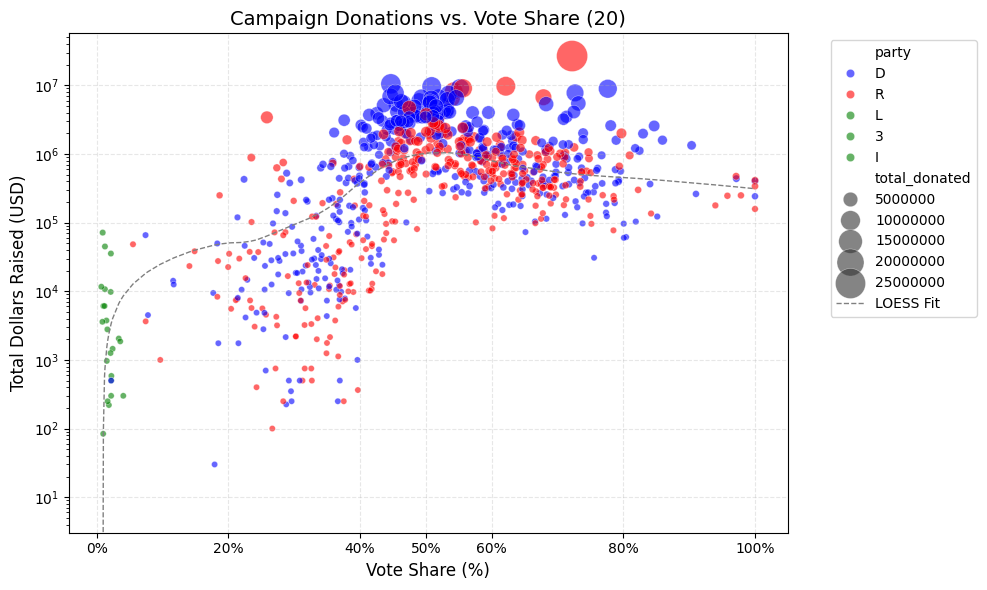

In [76]:
df = df.dropna(subset=['voteshare', 'total_donated'])
lowess = sm.nonparametric.lowess
loess_fit = lowess(
    df['total_donated'], 
    df['voteshare'], 
    frac=0.4
)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='voteshare', 
    y='total_donated',
    hue='party',
    size='total_donated',
    sizes=(20, 500),
    palette={'R': 'red', 'D': 'blue', 'L': 'green', 'I': 'green', '3': 'green'},
    alpha=0.6,
)

plt.plot(loess_fit[:, 0], loess_fit[:, 1], 
         color='grey', 
         linewidth=1, 
         linestyle='--',
         label='LOESS Fit')

plt.title(f"Campaign Donations vs. Vote Share ({year})", fontsize=14)
plt.xlabel("Vote Share (%)", fontsize=12)
plt.ylabel("Total Dollars Raised (USD)", fontsize=12)
plt.xticks(ticks=[0, 20, 40, 50, 60, 80, 100], labels=['0%', '20%', '40%', '50%', '60%', '80%', '100%'])
plt.yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
df.sort_values(by="total_donated", ascending=False)[["recip_id", "name_y", "party", "state", "type", "total_donated", "voteshare"]][:10]

,recip_id,name_y,party,state,type,total_donated,voteshare
97,N00009660,Steve Scalise (R),R,VT,I,26704863.0,72.209505
645,N00041588,Max Rose (D),D,DC,I,10499458.0,44.673819
184,N00028152,Kevin McCarthy (R),R,CA,I,9691047.0,62.140090
612,N00041357,Elissa Slotkin (D),D,DC,I,9613642.0,50.875465
545,N00040853,Josh Harder (D),D,CA,I,9049576.0,55.163078
731,N00042224,Dan Crenshaw (R),R,TX,I,9040843.0,55.613943
82,N00007360,Nancy Pelosi (D),D,CA,I,8913313.0,77.634936
80,N00007248,Devin Nunes (R),R,CA,I,8246578.0,54.226230
95,N00009585,Adam Schiff (D),D,CA,I,7760797.0,72.656671
1302,N00045066,Wendy Davis (D),D,TX,C,7745305.0,45.350964


In [78]:
df_ind = merged[merged["ethnic"] == "ind"].groupby('recip_id').agg({
    'total_donated': 'sum',
    'name_y': 'first',
    'candidatevotes': 'first',
    'totalvotes': 'first',
    'party': 'first',
    'state': 'first',
    'type': 'first'
}).reset_index()

df_ind['voteshare'] = df_ind['candidatevotes'] / df_ind['totalvotes'] * 100

In [79]:
model = ols(formula='voteshare ~ total_donated + type + totalvotes', data=df_ind).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              voteshare   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     101.5
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           4.51e-74
Time:                        23:01:12   Log-Likelihood:                -1909.4
No. Observations:                 513   AIC:                             3831.
Df Residuals:                     507   BIC:                             3856.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        66.9721     10.465      6.399      0.000      46.411      87.533
type[T.C]       -12.1628     10.107     -1.203      0.229     -32.020       7.694
type[T.I]         9.5284     10.091      0.944      0.345     -10.297      29.354
type[T.O]        -0.3102     10.153     -0.031      0.976     -20.257      19.636
total_donated -1.813e-06   6.33e-06     -0.286      0.775   -1.42e-05    1.06e-05
totalvotes    -3.833e-05   6.72e-06     -5.702      0.000   -5.15e-05   -2.51e-05
==============================================================================
Omnibus:                       28.996   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.176
Skew:                           0.152   Prob(JB):                     1.94e-19
Kurtosis:                       4.985   Cond. No.                     1.68e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

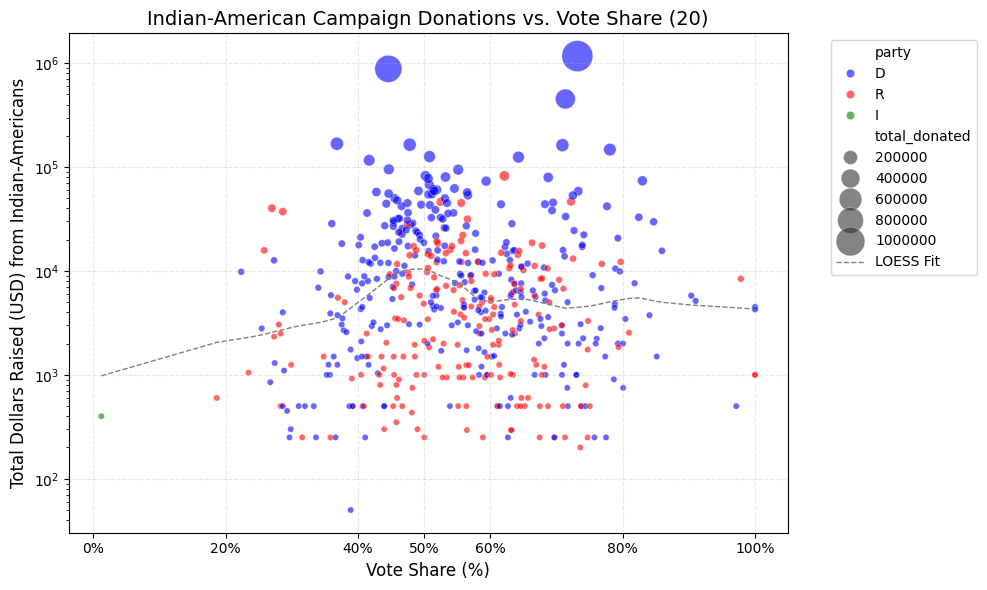

In [80]:
df_ind = df_ind.dropna(subset=['voteshare', 'total_donated'])
lowess = sm.nonparametric.lowess
loess_fit = lowess(
    df_ind['total_donated'], 
    df_ind['voteshare'], 
    frac=0.3
)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df_ind,
    x='voteshare', 
    y='total_donated',
    hue='party',
    size='total_donated',
    sizes=(20, 500),
    palette={'R': 'red', 'D': 'blue', 'L': 'green', 'I': 'green', '3': 'green'},
    alpha=0.6,
)

plt.plot(loess_fit[:, 0], loess_fit[:, 1], 
         color='grey', 
         linewidth=1, 
         linestyle='--',
         label='LOESS Fit')

plt.title(f"Indian-American Campaign Donations vs. Vote Share ({year})", fontsize=14)
plt.xlabel("Vote Share (%)", fontsize=12)
plt.ylabel("Total Dollars Raised (USD) from Indian-Americans", fontsize=12)
plt.xticks(ticks=[0, 20, 40, 50, 60, 80, 100], labels=['0%', '20%', '40%', '50%', '60%', '80%', '100%'])
plt.yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [81]:
df_ind.sort_values(by="total_donated", ascending=False)[["recip_id", "name_y", "party", "state", 'type', "total_donated", "voteshare"]][:10]

,recip_id,name_y,party,state,type,total_donated,voteshare
179,N00033240,Raja Krishnamoorthi (D),D,CA,I,1172497.0,73.160682
390,N00042142,Sri Kulkarni (D),D,TX,O,883193.0,44.602106
94,N00026427,Ro Khanna (D),D,CA,I,452515.0,71.345885
442,N00043981,Rishi Kumar (D),D,CA,C,167965.0,36.831338
335,N00041302,Hiral Tipirneni (D),D,CA,C,164255.0,47.827285
191,N00033508,Eric Swalwell (D),D,CA,I,162679.0,70.904666
417,N00042649,Rashida Tlaib (D),D,CA,I,147276.0,78.075100
350,N00041418,Abigail Spanberger (D),D,NY,I,126274.0,50.819542
436,N00043581,Ilhan Omar (D),D,NY,I,124761.0,64.265536
737,N00046315,Qasim Rashid (D),D,TX,C,116266.0,41.707313


In [82]:
donors_unique[(donors_unique["seat"] == "MI12") & (donors_unique["party"] != "X")][["seat", "party", "lastname", "level", "ran_general"]].value_counts()

seat  party  lastname  level  ran_general
MI12  D      dingell   House  Y              1
             rajput    House                 1
Name: count, dtype: int64

In [83]:
house20[(house20["seat"] == "MI12") & (house20["party"] != "X")][["seat", "party", "lastname"]].value_counts()

seat  party  lastname 
MI12  3      walkowicz    1
      D      dingell      1
      R      jones        1
Name: count, dtype: int64

In [84]:
# show mean voteshare by party
df_ind.groupby('party')['voteshare'].mean()

party
D    55.704202
I     1.229285
R    56.047568
Name: voteshare, dtype: float64

In [85]:
df_ind.groupby('party')['total_donated'].mean()

party
D    25783.717042
I      400.000000
R     6488.975124
Name: total_donated, dtype: float64

In [86]:
df.groupby('party')['voteshare'].mean()

party
3     1.444228
D    50.646741
I     1.275886
L     2.261781
R    51.190807
Name: voteshare, dtype: float64

In [87]:
df.groupby('party')['total_donated'].mean()

party
3    1.910067e+04
D    1.313899e+06
I    1.283900e+04
L    3.113417e+03
R    7.963834e+05
Name: total_donated, dtype: float64